# Teaching machines to see better: Improving CNNs and making them confess

In this we will discuss various techniques to improve the CNN, such as, data augmentation, dropout. We will then train a model that is better suited for our data. Finally we will learn about transfer learning, and leverage it to download a pretrained model and train an offspring that's better than any model we've seen so far.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch07-Improving-CNNs-and-Explaining/7.2.Transfer_Learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Importing necessary libraries <a class="anchor" id="import"></a>

In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.2


## Downloading data <a class="anchor" id="download-data"></a>

For this chapter, we're going to use the tiny-imagenet dataset (200 categories of objects). This is a simplified version of the bigger and harder imagenet dataset (1000 categories of objects).

In [2]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('../data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('../data'):
        os.mkdir('../data')
    
    # Write to a file
    with open(os.path.join('../data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('../data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('../data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('../data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


## Results from the EDA

* There are 200 classes of data
* Each image is 64x64 RGB
* Training data has 500 images per each class
* Testing has 50 images per each class
* We separate 50 images from each class in the training set to create the validation set

```
n02124075 	Egyptian cat
n04067472 	reel
n04540053 	volleyball
n04099969 	rocking chair, rocker
n07749582 	lemon
```

## Creating the data generators <a class="anchor" id="create-data-pipeline"></a>

In the dataset, we currently have a,

* Training set: `train` directory
* Testing set: `val` directory

But to properly train a model we need three datasets,

* Training set - Used to train the model
* Validation set - Used to continuously monitor model performance while training
* Testing set - Used to test the model, only after training finishes

Therefore, we will separate a 10% from training data and feed this data through as a separate generator

Additionally, we are going to create data generators that can augment data. Particularly we are going to use following augmentation techniques.

* Randomly rotate the image
* Randomly shift on width
* Randomly shift on height
* Random brightness adjustments
* Random shear adjustments
* Random zoom in/out
* Randomly flip horizontally
* Random gamma correction
* Randomly occlude a small patch

Note that, here we are changing the normalization method for images from,

* Mean centering 

to

* Bringing them to a range between `[-1, 1]`

<a id="pgfId-1124814" href=""></a><span class="fm-combinumeral">#1</span> Defines a data-augmenting image data generator and a standard image data generator<br>
<a id="pgfId-1124850" href=""></a><span class="fm-combinumeral">#2</span> Defines a partial function to avoid repeating arguments<br>
<a id="pgfId-1124867" href=""></a><span class="fm-combinumeral">#3</span> Uses a target size of 224 &times; 224<br>
<a id="pgfId-1124884" href=""></a><span class="fm-combinumeral">#4</span> Uses bilinear interpolation to make images bigger<br>
<a id="pgfId-1124901" href=""></a><span class="fm-combinumeral">#5</span> Defines the data generators for training and validation sets<br>
<a id="pgfId-1124918" href=""></a><span class="fm-combinumeral">#6</span> Defines the test data generator<br>
<a id="pgfId-1124935" href=""></a><span class="fm-combinumeral">#7</span> Uses a target size of 224 &times; 224 and bilinear interpolation<br>
<a id="pgfId-1124952" href=""></a><span class="fm-combinumeral">#8</span> Defines the batch size and target size<br>
<a class="calibre7" id="pgfId-1124815" href=""></a><span class="fm-combinumeral">#9</span> Gets the train/valid/test modified data generators using the data_gen_augmented function<br>

In [3]:
# Section 7.3
# Code listing 7.13

from functools import partial

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df


        

def get_train_valid_test_data_generators(batch_size, target_size):
    """ Get the training/validation/testing data generators """
    
    # Defining a data-augmenting image data generator and a standard image data generator
    image_gen_aug = ImageDataGenerator(
        samplewise_center=False, rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
        zoom_range=0.2, horizontal_flip=True, fill_mode='constant', cval=127.5, 
        validation_split=0.1
    )
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Define a training data generator
    partial_flow_func = partial(
        image_gen_aug.flow_from_directory, 
        directory=os.path.join('../data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation')    

    # Defining the test data generator
    test_df = get_test_labels_df(os.path.join('../data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('../data','tiny-imagenet-200',  'val', 'images'), target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen


def data_gen_augmented_inception_resnet_v2(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        
        if x.ndim != 4:
            raise ValueError("This function is designed for a batch of images with 4 dims [b, h, w, c]")
            
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.93, 1.06, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[1]-occ_size), np.random.randint(0, x.shape[2]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/imagenet_utils.py#L181
        x /= 127.5
        x -= 1

        yield x,y
        
        
batch_size = 48
target_size = (224,224)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_inception_resnet_v2(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_inception_resnet_v2(valid_gen)
test_gen_aux = data_gen_augmented_inception_resnet_v2(test_gen)


with open(os.path.join('../data','class_indices'), 'wb') as f:
    pickle.dump(train_gen.class_indices, f)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


## Training the model

Here we will train the model on augmented data with early stopping.

In [4]:
def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

## Pretrained Inception Resnet v2 network (`tf.keras.applications`)

Here, we create a Sequential `tf.keras.models.Model` by wrapping,

* An Input layer having the size 224x224x3
* The downloaded Inception Resnet v2 model (without the top prediction layer and an average pooling layer on top)
* A dropout layer with 40% dropout rate
* A final prediction layer

In [5]:
# Section 7.3
# Section 7.12

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

K.clear_session()

def get_inception_resnet_v2_pretrained():
    model = Sequential([
        Input(shape=(224,224,3)),
        InceptionResNetV2(include_top=False, pooling='avg'),
        Dropout(0.4),
        Dense(200, activation='softmax')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model 

model = get_inception_resnet_v2_pretrained()
model.summary()


219055592/219055592 [==============================] - 19s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 200)               307400    
                                                                 
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


## Training the Inception Resnet v2 based model

Here, we train the Inception Resnet v2 based model that has already been pretrained with ImageNet data. You should get a validation accuracy close to 75% by training this model.

In [6]:
# Section 7.3

def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [20]:
# Section 7.3

from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

n_epochs=1

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)), batch_size), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)), batch_size),
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)

1875/1875 [==============================] - 2048s 1s/step - loss: 0.1036 - accuracy: 0.9704 - val_loss: 1.2381 - val_accuracy: 0.7545 - lr: 1.0000e-06


## Save the model to the disk

In [21]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_resnet_v2.h5'))

## Get test accuracy of the trained Inception Resnet v2 based model

In [9]:
K.clear_session()
# Load the model from disk
try: 
    model = load_model(os.path.join('models','inception_resnet_v2.h5'))
except:
    # Sometimes loading the above model result in ValueError: Unknown layer: Functional
    print("Model loading failed. Trying a different method")
    model = get_inception_resnet_v2_pretrained()
    model.load_weights(os.path.join('models','inception_resnet_v2.h5'))

print("Model was successfully loaded")
# Evaluate the model
test_res = model.evaluate(test_gen_aux, steps=get_steps_per_epoch(500*50, batch_size))

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

Model was successfully loaded
521/521 [==============================] - 254s 481ms/step - loss: 1.0733 - accuracy: 0.7889
{'loss': 1.07334566116333, 'accuracy': 0.788887083530426}


## Plotting the loss and accuracy of different models

['eval\\2_eval_data_aug_early_stopping.log', 'eval\\3_eval_minception.log', 'eval\\4_eval_resnet_pretrained.log']


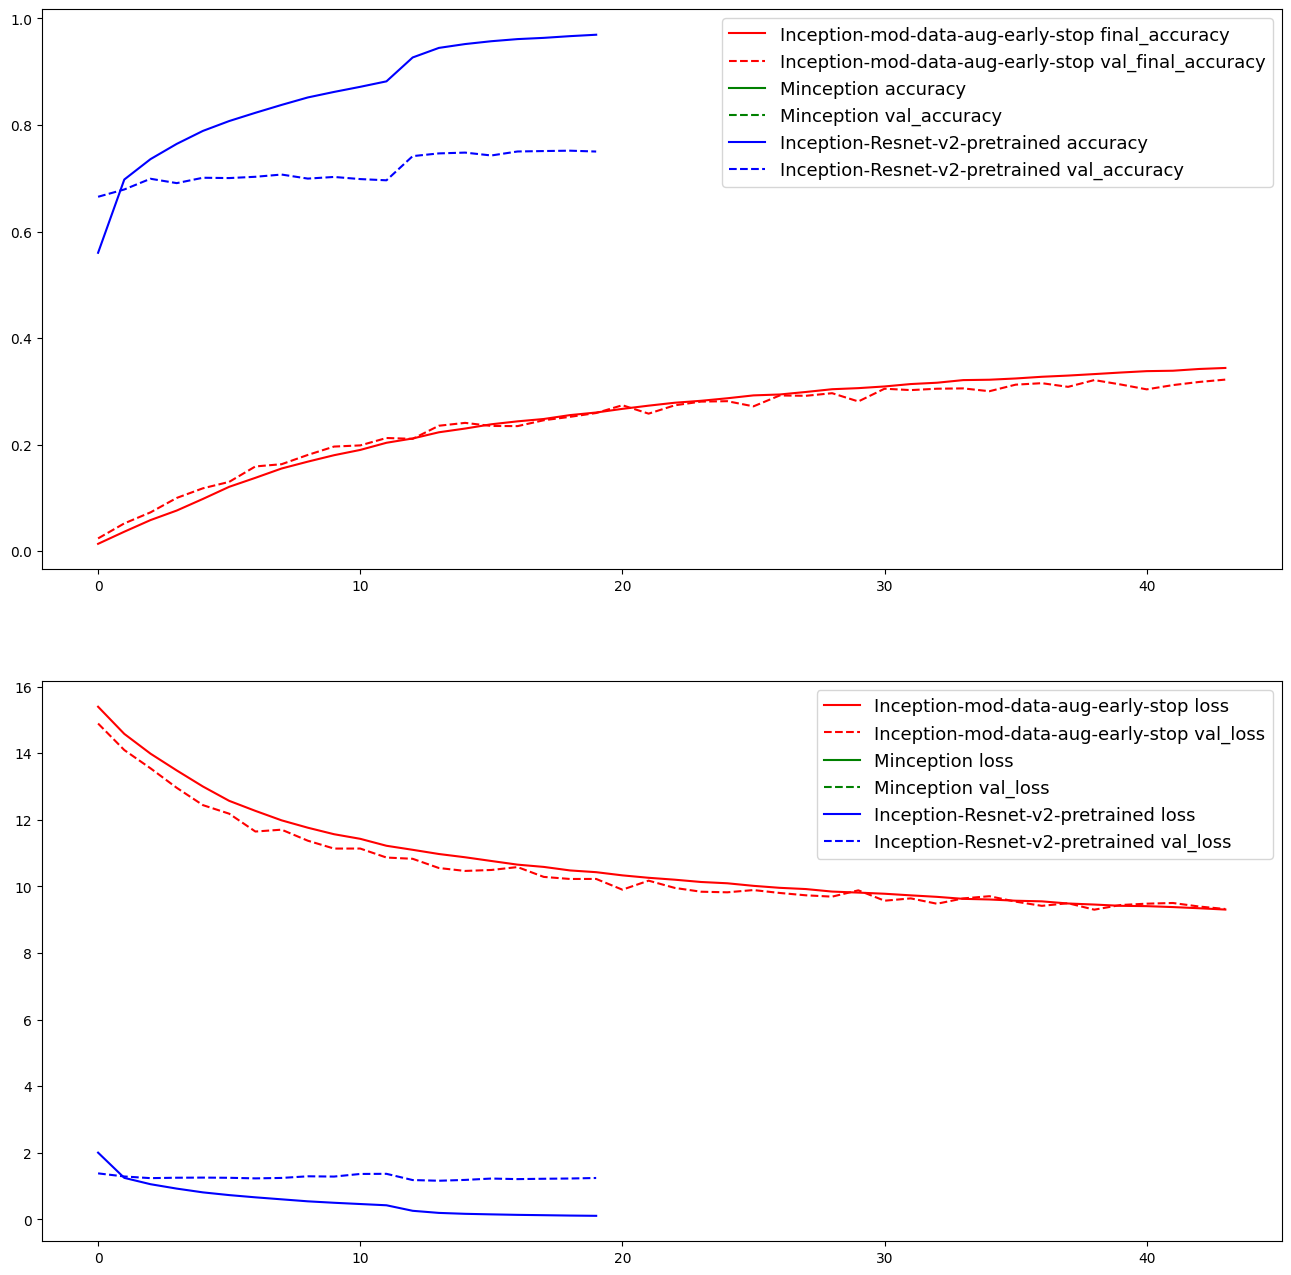

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(files, metrics, labels=None, linestyles=None, marker_styles=None, colors=None):
    data = {}    
    
    for i, f in enumerate(files):
        df = pd.read_csv(f, header=0, index_col=0)        
        if labels is not None:
            data[labels[i]] = df
        else:
            data[f] = df
            
    fig, axes = plt.subplots(len(metrics), 1, figsize=(16,16))
    
    for m, ax in zip(metrics, axes):        
        met_df = []
        for i, (lbl, df) in enumerate(data.items()):
            train_m, val_m = None, None
            for c in df.columns:
                if m in c and 'val' not in c:
                    train_m = c
                elif m in c and 'val' in c:
                    val_m = c
                    
            if linestyles is not None:
                ax.plot(df.index, df[train_m], linestyle=linestyles[0], color=colors[i], label=lbl+' '+train_m)
                ax.plot(df.index, df[val_m], linestyle=linestyles[1], color=colors[i], label=lbl+' '+val_m)
            else:
                ax.plot(df.index, df[train_m], label=lbl)
                ax.plot(df.index, df[val_m], label=lbl)
        ax.legend(fontsize=13)
    
files = [os.path.join('eval',f) for f in sorted(os.listdir('eval'))]  
print(files)
metrics = ['accuracy', 'loss']
linestyles= ['-', '--']
labels = ['Inception-mod-data-aug-early-stop', 'Minception', 'Inception-Resnet-v2-pretrained']
colors = ['r', 'g', 'b', 'purple']
plot_metrics(files, metrics, labels, linestyles=linestyles, colors=colors)

## Bonus: More fine-grained test accuracy 

Here we will look at test accuracies per class. This way we can know which classes the model is really good at and which classes are the classes model gets wrong mostly.

## Generating predictions for test data

In [11]:
K.clear_session()

# Load the model from disk
try: 
    model = load_model(os.path.join('models','inception_resnet_v2.h5'))
except:
    # Sometimes loading the above model result in ValueError: Unknown layer: Functional
    print("Model loading failed. Trying a different method")
    model = get_inception_resnet_v2_pretrained()
    model.load_weights(os.path.join('models','inception_resnet_v2.h5'))

print("Model was successfully loaded")

# Generating predictions
test_gen_aux = data_gen_augmented_inception_resnet_v2(test_gen)
test_preds = model.predict(test_gen_aux, steps=get_steps_per_epoch(500*20, batch_size))
test_preds = np.argmax(test_preds, axis=-1)

Model was successfully loaded
209/209 [==============================] - 22s 88ms/step


## Add the predicted class for each class (majority vote)

In [12]:
def get_tiny_imagenet_classes(wnids_path, words_path):
    " Get the tiny imagenet class names "
    wnids = pd.read_csv(wnids_path, header=None, squeeze=True)
    words = pd.read_csv(words_path, sep='\t', index_col=0, header=None)
    words_200 = words.loc[wnids].rename({1:'class'}, axis=1)
    words_200.index.name = 'wnid'
    return words_200.reset_index()

def get_best_and_worst_classes(label_df, test_preds, class_indices):
        
    def accuracy(x):
        """ Computing the accuracy """
        return (x["pred_label"]==x["true_label"].iloc[0]).sum()/x.shape[0]
    
    # Create a copy
    test_results = label_df.copy()
    
    # True labels
    test_results["true_label"] = test_results["class"].map(class_indices)
    # Predicted labels are computed earlier
    test_results["pred_label"] = test_preds
    
    # Compute accuracy per class
    per_class_acc = test_results[["class", "true_label", "pred_label"]].groupby("class").apply(
        lambda x: accuracy(x)).sort_values()
    
    # Get label names
    labels = get_tiny_imagenet_classes(wnids_path, words_path).set_index("wnid")["class"]
    per_class_acc = pd.DataFrame(per_class_acc, index=per_class_acc.index, columns=["accuracy"])
    per_class_acc.loc[labels.index, "class_description"] = labels
    
    # Printing the results
    print("Worst performing classes")
    print("="*50)
    print(per_class_acc.head(n=10))
    print("\nBest performing classes")
    print("="*50)
    print(per_class_acc.tail(n=10))
    return {'best': per_class_acc.iloc[-10:], 'worst': per_class_acc.iloc[:10]}

data_dir = os.path.join('../data', 'tiny-imagenet-200')
wnids_path = os.path.join(data_dir, 'wnids.txt')
words_path = os.path.join(data_dir, 'words.txt')

test_df = get_test_labels_df(os.path.join('../data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
class_indices = test_gen.class_indices
best_and_worst_cls = get_best_and_worst_classes(test_df, test_preds, class_indices)

C:\Users\carlos\AppData\Local\Temp\ipykernel_12548\2062757969.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  wnids = pd.read_csv(wnids_path, header=None, squeeze=True)


Worst performing classes
           accuracy              class_description
class                                             
n03250847       0.0                      drumstick
n03388043       0.0                       fountain
n03393912       0.0                    freight car
n03404251       0.0                       fur coat
n04560804       0.0                      water jug
n03444034       0.0                        go-kart
n03447447       0.0                        gondola
n03544143       0.0                      hourglass
n03584254       0.0                           iPod
n03599486       0.0  jinrikisha, ricksha, rickshaw

Best performing classes
           accuracy                                  class_description
class                                                                 
n03160309      0.02                                    dam, dike, dyke
n03424325      0.02                    gasmask, respirator, gas helmet
n12267677      0.02                                   

## Plotting the wrapped model

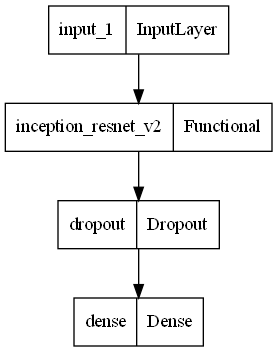

In [18]:
tf.keras.utils.plot_model(model)

## Plotting the Inception Resnet v2 model

In [19]:
tf.keras.utils.plot_model(model.layers[0], to_file='resnet.png')